In [1]:
#library installations
%pip install pydicom SimpleITK numpy
%pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

Note: you may need to restart the kernel to use updated packages.
INFO: pip is looking at multiple versions of pylibjpeg-libjpeg to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install pylibjpeg-libjpeg==2.3.0 and pylibjpeg==2.0.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    pylibjpeg 2.0.1 depends on numpy
    pylibjpeg-libjpeg 2.3.0 depends on numpy<3.0 and >=2.0

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install python-gdcm

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install scikit-image==0.22.0

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --force-reinstall numpy==1.25.2 scikit-image==0.22.0

ERROR: Could not find a version that satisfies the requirement numpy==1.25.2 (from versions: none)
ERROR: No matching distribution found for numpy==1.25.2
Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install monai

Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [9]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import pydicom
import numpy as np
import SimpleITK as sitk

def load_dicom_volume(folder_path):
    # Load all DICOM files in the folder
    dicoms = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.dcm'):
            dicom = pydicom.dcmread(os.path.join(folder_path, filename))
            dicoms.append(dicom)

    # Sort slices by ImagePositionPatient or InstanceNumber
    dicoms.sort(key=lambda x: float(x.ImagePositionPatient[2]) if 'ImagePositionPatient' in x else int(x.InstanceNumber))

    # Stack slices into 3D array
    image_stack = np.stack([d.pixel_array for d in dicoms])

    # Get spacing info
    try:
        spacing = list(map(float, dicoms[0].PixelSpacing))  # in-plane spacing
        slice_thickness = float(dicoms[0].SliceThickness)
        spacing.append(slice_thickness)
    except:
        spacing = [1.0, 1.0, 1.0]  # fallback if tags missing

    return image_stack, spacing

In [12]:
def resample_volume(volume, original_spacing, new_spacing=[1.0, 1.0, 1.0]):
    original_spacing = np.array(original_spacing[::-1])  # DICOM order: z, y, x
    new_spacing = np.array(new_spacing)
    
    resize_factor = original_spacing / new_spacing
    new_shape = np.round(np.array(volume.shape) * resize_factor).astype(int)

    volume_sitk = sitk.GetImageFromArray(volume)
    volume_sitk.SetSpacing(original_spacing.tolist())

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing.tolist())
    resampler.SetSize([int(s) for s in new_shape[::-1]])
    resampler.SetInterpolator(sitk.sitkLinear)

    resampled = resampler.Execute(volume_sitk)
    return sitk.GetArrayFromImage(resampled)

In [13]:
def normalize_ct(volume, clip_min=-1000, clip_max=400):
    volume = np.clip(volume, clip_min, clip_max)
    volume = (volume - clip_min) / (clip_max - clip_min)  # normalize to [0, 1]
    return volume.astype(np.float32)

In [14]:
def load_and_process_dicom(folder_path):
    volume, spacing = load_dicom_volume(folder_path)
    resampled = resample_volume(volume, spacing, [1.0, 1.0, 1.0])
    normalized = normalize_ct(resampled)
    return normalized  # shape: (D, H, W)

In [15]:
import numpy as np

def get_10_montage_slices(volume):
    """Divide the volume into 10 sections and sample the center slice from each (sequentially)"""
    depth = volume.shape[0]  # z-dimension (axial slices)
    section_size = depth // 10
    slices = []

    for i in range(10):
        start = i * section_size
        end = (i + 1) * section_size if i < 9 else depth
        center_idx = (start + end) // 2
        slices.append(volume[center_idx])

    montage = np.stack(slices, axis=0)  # shape: (10, H, W), ordered top→bottom
    return montage

In [16]:
from skimage.transform import resize

def preprocess_slice(slice_2d):
    slice_2d = np.clip(slice_2d, -1000, 400)
    slice_2d = (slice_2d + 1000) / 1400
    slice_2d = resize(slice_2d, (224, 224), mode='reflect', anti_aliasing=True)
    return slice_2d.astype(np.float32)

In [17]:
def create_montage_tensor(volume):
    slices = get_10_montage_slices(volume)
    slices = [preprocess_slice(s) for s in slices]
    montage = np.stack(slices)  # shape: (10, H, W)
    montage = montage[:, np.newaxis, :, :]  # (10, 1, H, W)
    montage = np.transpose(montage, (1, 0, 2, 3))  # (1, 10, H, W)
    tensor = torch.tensor(montage, dtype=torch.float32)  # (1, 10, 224, 224)
    tensor = tensor.unsqueeze(0)  # add batch dim: (B=1, C=1, D=10, H, W)
    return tensor

In [18]:
import torch
from torch.utils.data import Dataset
import pandas as pd

class DicomMontageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        patient_id = self.labels_df.iloc[idx]['patient_id']
        label = self.labels_df.iloc[idx]['label']
        dicom_folder = os.path.join(self.root_dir, patient_id)
        
        # Process volume
        volume = load_and_process_dicom(dicom_folder)
        tensor = create_montage_tensor(volume)

        if self.transform:
            tensor = self.transform(tensor)
            
        return tensor.squeeze(0), torch.tensor(label, dtype=torch.long)

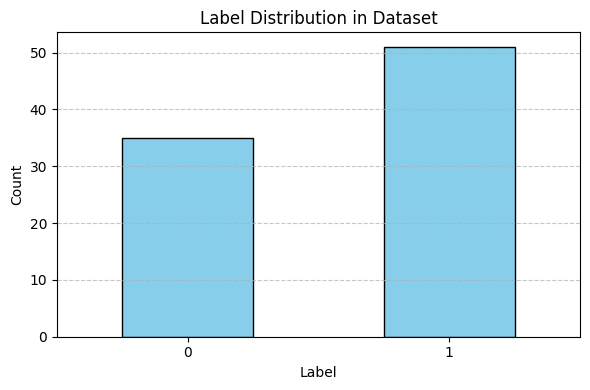

In [19]:
#visualize the data breakdown
import matplotlib.pyplot as plt

# Load your CSV file
csv_file = 'dataset/labels_8_weeks.csv'
labels_df = pd.read_csv(csv_file)

# Count each label type
label_counts = labels_df['label'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in Dataset')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [20]:
#partition the dataset into train:validate:test 75%:12.5%:12.5%

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm

# Wrap dataset access in try-except to catch loading errors
def safe_get_label(dataset, idx):
    try:
        _, label = dataset[idx]
        return label
    except Exception as e:
        # Attempt to get patient ID if available; adjust attribute as per your dataset
        patient_id = getattr(dataset, 'patient_ids', None)
        pid = patient_id[idx] if patient_id is not None else f"index {idx}"
        print(f"Warning: Skipping patient {pid} due to error: {e}")
        return None

# full dataset and loader (keep loader for convenience, may skip corrupted later)
dataset = DicomMontageDataset(csv_file='dataset/labels_8_weeks.csv', root_dir='dataset')
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

# Collect valid indices and labels with error handling
valid_indices = []
valid_labels = []
print("Extracting labels and filtering corrupted samples:")
for idx in tqdm(range(len(dataset))):
    label = safe_get_label(dataset, idx)
    if label is not None:
        valid_indices.append(idx)
        valid_labels.append(label)

# Now do stratified splits on filtered valid data only
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_rel_idx, temp_rel_idx in sss1.split(X=valid_labels, y=valid_labels):
    pass

# Get absolute indices from relative
train_idx = [valid_indices[i] for i in train_rel_idx]
temp_idx = [valid_indices[i] for i in temp_rel_idx]

# Split temp into val and test (50% each)
temp_labels = [valid_labels[i] for i in temp_rel_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_rel_idx, test_rel_idx in sss2.split(X=temp_labels, y=temp_labels):
    pass

val_idx = [temp_idx[i] for i in val_rel_idx]
test_idx = [temp_idx[i] for i in test_rel_idx]

# Create subsets using filtered and split indices
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


Extracting labels and filtering corrupted samples:


100%|████████████████████████████████████████████████████████████████████| 86/86 [04:40<00:00,  3.26s/it]


In [21]:
#Create the model

from monai.networks.nets import SEResNet50
import torch.nn as nn
import torch

# Load pretrained SE-ResNet50 3D
# Create SE-ResNet50 3D model for binary classification
model = SEResNet50(
    spatial_dims=3,
    in_channels=1,      # Use this instead of n_input_channels
    num_classes=4       # For binary classification
)

# Optional: move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

## Optionally freeze early layers to prevent fine tuning the whole network
# for param in model.layer1.parameters():
#     param.requires_grad = False

num_epochs = 10

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)  # (B, 1, 10, 224, 224)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)

            val_loss += loss.item()
            _, val_predicted = val_outputs.max(1)
            val_correct += val_predicted.eq(val_labels).sum().item()
            val_total += val_labels.size(0)

    val_acc = 100 * val_correct / val_total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%\n")


Epoch 1/10, Train Loss: 7.8942, Train Accuracy: 43.75%
Validation Loss: 2.0227, Validation Accuracy: 63.64%

Epoch 2/10, Train Loss: 5.6996, Train Accuracy: 59.38%
Validation Loss: 1.6471, Validation Accuracy: 36.36%

Epoch 3/10, Train Loss: 5.7712, Train Accuracy: 53.12%
Validation Loss: 1.4429, Validation Accuracy: 36.36%

Epoch 4/10, Train Loss: 5.7000, Train Accuracy: 51.56%
Validation Loss: 1.4708, Validation Accuracy: 36.36%

Epoch 5/10, Train Loss: 5.6129, Train Accuracy: 59.38%
Validation Loss: 1.4671, Validation Accuracy: 63.64%

Epoch 6/10, Train Loss: 5.5801, Train Accuracy: 53.12%
Validation Loss: 1.7933, Validation Accuracy: 63.64%

Epoch 7/10, Train Loss: 5.9023, Train Accuracy: 59.38%
Validation Loss: 2.3829, Validation Accuracy: 63.64%

Epoch 8/10, Train Loss: 5.3938, Train Accuracy: 59.38%
Validation Loss: 2.6335, Validation Accuracy: 63.64%

Epoch 9/10, Train Loss: 5.1881, Train Accuracy: 65.62%
Validation Loss: 1.8003, Validation Accuracy: 63.64%

Epoch 10/10, Train 

In [22]:
#Test the model 
def test_model(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for speed
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

test_model(model, test_loader, criterion, device)


Test Loss: 0.6816, Test Accuracy: 54.55%


(0.6816262304782867, 54.54545454545455)